In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans  # distances to k cluster centroids
from sklearn.cluster import DBSCAN  # density based for irregular shaped clusters
from sklearn.mixture import GaussianMixture  # center (μ), shape & orientation (∑), weight (ϕ)
from sklearn.mixture import BayesianGaussianMixture  # helps to remove unnecessary clusters

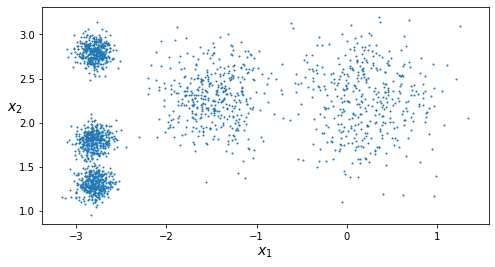

In [2]:
# load and plot the cluster dataset
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)  # y is unknown for unsupervised learning

plt.figure(figsize=(8, 4))
plt.scatter(X[:, 0], X[:, 1], s=1)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0);

In [3]:
# clearly there are 5 clusters
k = 5
kmeans = KMeans(n_clusters=k)  # random initial cluster centroids, default run for 10 times
y_pred = kmeans.fit_predict(X)
y_pred

array([0, 4, 3, ..., 2, 3, 4], dtype=int32)

In [4]:
y  # provided by make_blobs dataset

array([4, 2, 0, ..., 3, 0, 2])

In [5]:
kmeans.cluster_centers_

array([[-2.80037642,  1.30082566],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999]])

In [6]:
blob_centers  # provided by make_blobs dataset

array([[ 0.2,  2.3],
       [-1.5,  2.3],
       [-2.8,  1.8],
       [-2.8,  2.8],
       [-2.8,  1.3]])

In [7]:
kmeans.inertia_  # performace metric that measures mean squared distances from all centroids

211.59853725816828

In [8]:
kmeans.score(X)  # no y as unsupervised

-211.5985372581683

In [9]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([3, 3, 2, 2], dtype=int32)

In [10]:
kmeans.transform(X_new)  # 5 distances to 5 centroids for each of the 4 instances

array([[2.88633901, 1.49439034, 2.9042344 , 0.32995317, 2.81093633],
       [5.84236351, 4.4759332 , 5.84739223, 2.80290755, 5.80730058],
       [1.71086031, 1.69136631, 0.29040966, 3.29399768, 1.21475352],
       [1.21567622, 1.54808703, 0.36159148, 3.21806371, 0.72581411]])

In [11]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])  # guess initial centroids locations
kmeans_guessed = KMeans(n_clusters=k, init=good_init, n_init=1)  # initialise once with the good guess
kmeans_guessed.fit(X)

kmeans_guessed.inertia_

211.5985372581683

In [12]:
# classification with standard logistic regression
X_digits, y_digits = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.96

In [13]:
# pre-process data with KMeans to boost classification performance:
pipeline = Pipeline([('kmeans', KMeans(n_clusters=50)),  # to reduce dimensionality
                     ('log_reg', LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000))])
pipeline.fit(X_train, y_train)  
pipeline.score(X_test, y_test)  # transformed data are more linearly separable

0.9755555555555555

In [14]:
# now we can use grid search to find the best n_clusters parameter 
# as grid search is only compatible with supervised learning (LR in the pipeline)
param_grid = {'kmeans__n_clusters': range(2, 100)}  # double underscore!
grid_clf = GridSearchCV(pipeline, param_grid, cv=3)
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_)
grid_clf.score(X_test, y_test)

{'kmeans__n_clusters': 81}


0.9844444444444445

In [35]:
# semi-supervised learning (few labeled data)
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)  # distance to each centroid
representative_digit_idx = np.argmin(X_digits_dist, axis=0)  # the closest instance to each centroid
representative_digit_idx

array([ 110, 1092,  539,  345, 1240,  392,  896,  726, 1273, 1003, 1061,
       1136, 1305,  511,  676,  386,    6,  141,  627,  341,  577, 1232,
        490,  142,  579,  621,  330,  467, 1042,  623, 1035,  768,  322,
        457,  971,  499, 1149, 1036,  748,  769, 1109,   30, 1040, 1192,
       1058,  880,  810, 1038,  689,  906])

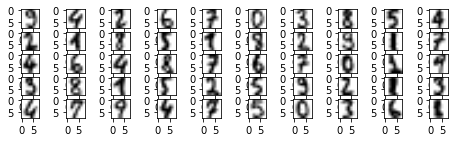

In [36]:
X_representative_digits = X_train[representative_digit_idx]

# plot these representative digits and manually lable the y's
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear");

In [37]:
# manually lable the y's as this is unsupervised learning
y_representative_digits = np.array([
    9, 4, 2, 6, 7, 0, 3, 8, 5, 4,
    2, 1, 8, 5, 1, 8, 2, 9, 1, 7,
    4, 6, 4, 8, 7, 6, 7, 0, 1, 9,
    3, 8, 1, 5, 2, 5, 9, 2, 1, 3,
    4, 7, 9, 4, 7, 5, 0, 3, 6, 1])

In [38]:
# now use these representative (~center of each cluster) instances to train the whole dataset
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)  # (if we had those y_test labels)

0.8866666666666667

In [39]:
kmeans.labels_

array([27, 25, 35, ..., 45,  7, 12], dtype=int32)

In [41]:
# propagate the representative instances to all instances based on cluster labels
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]  # k distinct clusters

# now use this to train the whole dataset     
log_reg_propagated = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg_propagated.fit(X_train, y_train_propagated)
log_reg_propagated.score(X_test, y_test)

0.9133333333333333

In [53]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)  # radius, number of points required within the radius
dbscan.fit(X)

DBSCAN(eps=0.05)

In [55]:
dbscan.labels_[:20]  # '-1' indicates outliers (not clustered)

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5,  2,  3,  0,  2,  2,  2,  4,
        2,  2,  4])

In [57]:
len(dbscan.core_sample_indices_)  # count instances clustered (i.e. excl. outliers)

808

In [56]:
dbscan_better = DBSCAN(eps=0.2, min_samples=5)  # wider scan to cover the 'outliers'
dbscan_better.fit(X)
dbscan_better.labels_[:20]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1])

In [58]:
len(dbscan_better.core_sample_indices_)

1000

In [60]:
dbscan_better.components_[:5]  # clustered core instances (X)

array([[-0.02137124,  0.40618608],
       [ 0.97670045, -0.45832306],
       [ 0.90405882, -0.37651952],
       [ 0.37736316, -0.39703717],
       [-0.84192557,  0.53058695]])

In [71]:
# DBSCAN does NOT have a .predict() method so we have to follow up with other algorithms
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan_better.components_, 
        dbscan_better.labels_[dbscan_better.core_sample_indices_])  # fit clustered instances to knn classifier

X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
y_pred = knn.predict(X_new)  # use KNN to predict based on clusters fit with DBSCAN
y_pred

array([1, 0, 1, 0])

In [72]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

In [73]:
# we can also control if a prediction should be an outlier (anomaly)
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_dist, y_pred_idx  # new instances' distance to the closest neighbor and the id of that neighbor 

(array([[0.43045422],
        [0.02225568],
        [0.06010476],
        [0.48399468]]),
 array([[909],
        [325],
        [915],
        [231]]))

In [75]:
# make instances further than 0.2 distances from the closest neighbor an outlier
y_pred.reshape(-1, 1)[y_dist > 0.2] = -1  
y_pred.ravel()

array([-1,  0,  1, -1])

In [76]:
# prepare data for Gaussian Mixture Model (EM algorithm)
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [78]:
gmm = GaussianMixture(n_components=3, n_init=10)  # 3 Gaussian clusters, repeat 10 times
gmm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [79]:
gmm.weights_  # probability that data fall in each cluster

array([0.20970929, 0.40008431, 0.3902064 ])

In [80]:
gmm.means_  # cluster centers

array([[ 3.39854326,  1.05926051],
       [-1.4076241 ,  1.42704927],
       [ 0.0512132 ,  0.07512971]])

In [81]:
gmm.covariances_  # cluster shape and orientation

array([[[ 1.14901133, -0.03241901],
        [-0.03241901,  0.95484861]],

       [[ 0.63480459,  0.72971575],
        [ 0.72971575,  1.16110086]],

       [[ 0.68780591,  0.79597839],
        [ 0.79597839,  1.21232694]]])

In [82]:
gmm.converged_  # check if the model converges in the end

True

In [83]:
gmm.n_iter_  # check the number of EM iterations to convergence

4

In [84]:
gmm.predict(X)  # 3 Gaussian clusters

array([2, 2, 1, ..., 0, 0, 0])

In [85]:
gmm.predict_proba(X)  # probabilities based on Gaussian distribution

array([[2.33107018e-02, 6.80230786e-07, 9.76688618e-01],
       [1.65481663e-02, 6.77302883e-04, 9.82774531e-01],
       [2.04358925e-06, 9.99923748e-01, 7.42085667e-05],
       ...,
       [9.99999578e-01, 2.17682412e-26, 4.21582331e-07],
       [1.00000000e+00, 1.50345348e-41, 4.93027253e-16],
       [1.00000000e+00, 8.24833927e-41, 2.19825399e-15]])

In [87]:
densities = gmm.score_samples(X)  
densities  # log of probability distribution function for each instance (within its Gaussian cluster)

array([-2.60753797, -3.57117632, -3.32962239, ..., -3.51337454,
       -4.39800533, -3.80760349])

In [88]:
np.exp(densities)

array([0.07371581, 0.02812275, 0.03580662, ..., 0.0297962 , 0.01230185,
       0.02220132])

In [90]:
# anomaly detection (rid of the lowest probability instances)
density_threshold = np.percentile(densities, 4)  # cut off at the lowest 4%
anomalies = X[densities < density_threshold]

In [91]:
# performance metrics for GMM are based on MLE vs. size of data and feature space - lower the better
gmm.bic(X)  # Bayesian Information Criterion ~fn(m, n, -log(L))

8189.756836104972

In [92]:
gmm.aic(X)  # Akaike Information Criterion ~fn(n, -log(L))

8102.531555989934

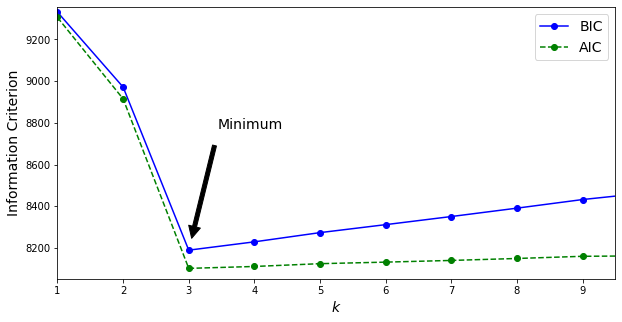

In [97]:
# AIC and BIC determine the optimal number of clusters (k) to set in GMM
gmms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
              for k in range(1, 11)]
bics = [model.bic(X) for model in gmms_per_k]
aics = [model.aic(X) for model in gmms_per_k]

# plot the BIC's and AIC's against k - find the lowest point
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend(fontsize=14);  # indeed the optimal k is 3 Gaussian clusters

In [99]:
# alternatively, use Bayesian GMM to determine the optimal number of clusters
bgmm = BayesianGaussianMixture(n_components=10, n_init=10)  # set a high enough k to start with
bgmm.fit(X)
np.round(bgmm.weights_, 2)  # the weights indicate importance of each of k clusters

array([0.  , 0.21, 0.39, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [100]:
# indeed we need only 3 clusters